# Graph Embeddings
The purpose of this notebook is to try out different graph embeddings.

In [2]:
from node2vec import Node2Vec
from pathlib import Path
from pyvis.network import Network
from src.configuration import load_dataset, ROOT_DIR
from src.features.encoder_utils import get_metafeatures, load_graph
from src import configuration as config

In [3]:
DATA_DIR = ROOT_DIR / "data/raw"
df = load_dataset(DATA_DIR / "dataset.csv")

In [4]:
# ---- get the encoder graph
G = load_graph(config.ROOT_DIR / "data/external/graphs/encodings_graph.adjlist")

In [5]:
# -- embed the graph

# Embed the graph.
# Parameters:
# G: Graph, which will be embedded.
# dimension: Dimension of the embedding. Higher dimensions may lead to better embeddings
# walk_length: Length of the random walks to be generated for each node in the graph
# num_walks: The number of random walks started from each node in the graph. E.g. if set to 1000 and workers is set to 2, 2000 walks in total are generated
# workers: Number of parallel processes.
# quiet: Suppress progress messages
# p: 
n2v = Node2Vec(G, dimensions=2, walk_length=20, num_walks=1000, workers=1, quiet=True)
n2v_model = n2v.fit()

# Get the embeddings.
node2vec_embeddings = {node: n2v_model.wv.get_vector(node) for node in n2v_model.wv.index_to_key}

# ...  You can then build an encoder with the embedding


# ... If you embed in 2d, you can plot an annotatate scatter plot of the embedding to see if it worked as expected

In [6]:
# print out the embeddings dictionary
for node, embedding in node2vec_embeddings.items():
    print(f"{node}: {embedding}")

supervised: [-0.3649559  -0.58046275]
unsupervised: [-2.9973733  -0.20256539]
bucvglmm: [ 0.6690966 -4.248176 ]
cvglmm: [ 0.67397445 -4.262166  ]
identifier: [-5.327637   -0.30738625]
bucvte: [-0.7724859 -0.5195421]
cvte: [-0.7373286 -0.5457166]
dte: [-0.36874112 -0.81058306]
mee: [-0.3991045 -0.7684103]
pbte: [-0.38284948 -0.76950055]
glmm: [ 0.39300635 -2.8390539 ]
te: [-0.5767943  -0.57871276]
encoder: [-1.2248316 -0.2264717]
OHE: [-5.2649913  -0.29054192]
BE: [-5.3987317 -0.3080047]
BUCV10RGLMME: [ 0.7198597 -4.4001045]
BUCV2RGLMME: [ 0.71070844 -4.447512  ]
BUCV5RGLMME: [ 0.7083105 -4.3456235]
CV2RGLMME: [ 0.708823 -4.387359]
BUCV2TE: [-0.8098271  -0.48981425]
BUCV10TE: [-0.80205745 -0.50205386]
CV10TE: [-0.7315836  -0.54653925]
CV5RGLMME: [ 0.7133998 -4.3725166]
BUCV5TE: [-0.7924279 -0.5024718]
DE: [-3.0615735  -0.20254467]
CV2TE: [-0.7574509 -0.5306661]
OE: [-5.3306355  -0.29140288]
CV10RGLMME: [ 0.70664555 -4.349461  ]
SE: [-3.0452452  -0.23372044]
CE: [-3.094955   -0.20737879]

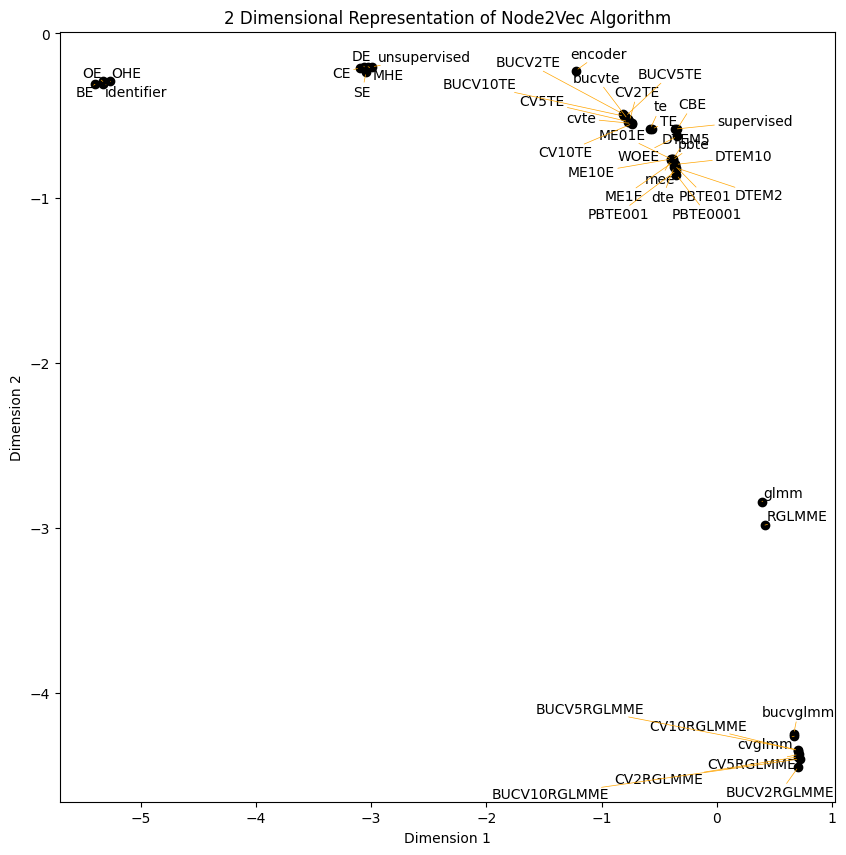

In [7]:
# visualize node embeddings
import matplotlib.pyplot as plt
from adjustText import adjust_text

x_coord = [n2v_model.wv.get_vector(str(x))[0] for x in G.nodes()]
y_coord = [n2v_model.wv.get_vector(str(x))[1] for x in G.nodes()]

#plt.clf()
plt.figure(figsize=(10, 10))
plt.scatter(x_coord, y_coord, color="black")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("2 Dimensional Representation of Node2Vec Algorithm")


texts = []
for i, node in enumerate(G.nodes()):
     texts.append(plt.text(x_coord[i], y_coord[i], '%s' %node))
     
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='orange', lw=0.5))

# save as svg
plt.savefig(config.FIGURE_DIR / "graph_encoding/node2vec_embeddings.svg", format="svg")


In [8]:
train_df = config.load_traindata_for_regression()
print(train_df.head())

   dataset model tuning scoring      encoder  cv_score
0     1169   KNC  model     ACC  BUCV2RGLMME  0.650562
1     1169   KNC  model     ACC      BUCV2TE  0.650712
2     1169   KNC  model     ACC          CBE  0.626492
3     1169   KNC  model     ACC           CE  0.625839
4     1169   KNC  model     ACC   CV10RGLMME  0.652093


Apply k means as an encoder for the graph embeddings.

In [9]:
from sklearn.cluster import KMeans
import numpy as np

# Convert the embeddings to a numpy array.
X = np.array(list(node2vec_embeddings.values())).astype('double')

# Use KMeans clustering to cluster the embeddings into 10 clusters.
kmeans = KMeans(n_clusters=6, random_state=0).fit(X)

# Add a new column to the train_df dataframe for the cluster assignments.
train_df['cluster'] = 0

# Loop over the rows in the dataframe and assign the cluster labels.
for i, row in train_df.iterrows():
    node = row['encoder']
    embedding = node2vec_embeddings[node]
    cluster = kmeans.predict([embedding])[0]
    train_df.at[i, 'cluster'] = cluster

# Print the resulting dataframe.
print(train_df.head())

c:\Users\Marco\Workspace\phase-2\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


   dataset model tuning scoring      encoder  cv_score  cluster
0     1169   KNC  model     ACC  BUCV2RGLMME  0.650562        1
1     1169   KNC  model     ACC      BUCV2TE  0.650712        0
2     1169   KNC  model     ACC          CBE  0.626492        4
3     1169   KNC  model     ACC           CE  0.625839        2
4     1169   KNC  model     ACC   CV10RGLMME  0.652093        1


In [10]:
print(type(node2vec_embeddings))
print(node2vec_embeddings)

<class 'dict'>
{'supervised': array([-0.3649559 , -0.58046275], dtype=float32), 'unsupervised': array([-2.9973733 , -0.20256539], dtype=float32), 'bucvglmm': array([ 0.6690966, -4.248176 ], dtype=float32), 'cvglmm': array([ 0.67397445, -4.262166  ], dtype=float32), 'identifier': array([-5.327637  , -0.30738625], dtype=float32), 'bucvte': array([-0.7724859, -0.5195421], dtype=float32), 'cvte': array([-0.7373286, -0.5457166], dtype=float32), 'dte': array([-0.36874112, -0.81058306], dtype=float32), 'mee': array([-0.3991045, -0.7684103], dtype=float32), 'pbte': array([-0.38284948, -0.76950055], dtype=float32), 'glmm': array([ 0.39300635, -2.8390539 ], dtype=float32), 'te': array([-0.5767943 , -0.57871276], dtype=float32), 'encoder': array([-1.2248316, -0.2264717], dtype=float32), 'OHE': array([-5.2649913 , -0.29054192], dtype=float32), 'BE': array([-5.3987317, -0.3080047], dtype=float32), 'BUCV10RGLMME': array([ 0.7198597, -4.4001045], dtype=float32), 'BUCV2RGLMME': array([ 0.71070844, -4.

In [11]:
from gensim.models.poincare import PoincareModel

# Load the adjacency list and convert it into a list of edges.
edges = []
with open(config.ROOT_DIR / "data/external/graphs/encodings_graph.adjlist") as f:
    for line in f:
        nodes = line.strip().split()
        for neighbor in nodes[1:]:
            edges.append((nodes[0], neighbor))

# Training the Poincaré model.
p_model = PoincareModel(edges, size=2, negative=2)
p_model.train(epochs=100)

# Getting the embeddings.
poincare_embeddings = {node: p_model.kv.get_vector(node) for node in p_model.kv.key_to_index}


In [12]:
# print out the embeddings dictionary
for node, embedding in poincare_embeddings.items():
    print(f"{node}: {embedding}")

BE: [-0.62139662  0.49414553]
identifier: [-0.48435327  0.36759892]
BUCV10RGLMME: [-0.11025822  0.7767998 ]
bucvglmm: [-0.06330861  0.55843331]
BUCV10TE: [ 0.62395869 -0.00452171]
bucvte: [ 0.53580486 -0.00985008]
BUCV2RGLMME: [-0.05832136  0.64913611]
BUCV2TE: [ 0.61885997 -0.06137556]
BUCV5RGLMME: [-0.06477526  0.70555133]
BUCV5TE: [ 0.56581677 -0.03752753]
CBE: [ 0.07802395 -0.21982584]
supervised: [ 0.05895562 -0.1764891 ]
CE: [-0.26979462  0.22836811]
unsupervised: [-0.2432057   0.18268171]
CV10RGLMME: [-0.73868792 -0.22818995]
cvglmm: [-0.57183656 -0.18440922]
CV10TE: [0.47066074 0.33792338]
cvte: [0.40081622 0.24957814]
CV2RGLMME: [-0.64769012 -0.21070606]
CV2TE: [0.47986689 0.34013908]
CV5RGLMME: [-0.70613    -0.22362645]
CV5TE: [0.5981418  0.43669786]
DE: [-0.25629675  0.21680578]
DTEM10: [ 0.23561318 -0.6699202 ]
dte: [ 0.22930276 -0.58938388]
DTEM2: [ 0.30142966 -0.73465554]
DTEM5: [ 0.2758209  -0.73778302]
ME01E: [-0.2122761  -0.46102092]
mee: [-0.14376324 -0.31879087]
ME10

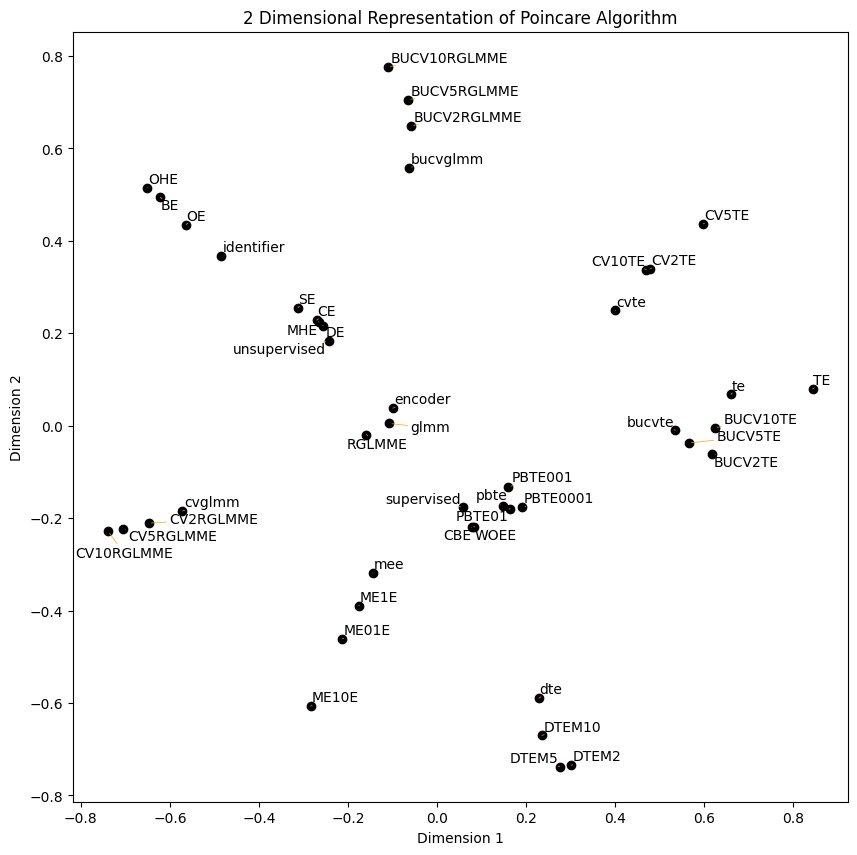

In [13]:
# visualize node embeddings
import matplotlib.pyplot as plt
from adjustText import adjust_text

x_coord = [p_model.kv.get_vector(str(x))[0] for x in G.nodes()]
y_coord = [p_model.kv.get_vector(str(x))[1] for x in G.nodes()]

#plt.clf()
plt.figure(figsize=(10, 10)) 
plt.scatter(x_coord, y_coord, color="black")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("2 Dimensional Representation of Poincare Algorithm")

texts = []
for i, node in enumerate(G.nodes()):
     texts.append(plt.text(x_coord[i], y_coord[i], '%s' %node))
     
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='orange', lw=0.5))

# save as svg
plt.savefig(config.FIGURE_DIR / "graph_encoding/poincare_embeddings.svg", format="svg")
